<a href="https://colab.research.google.com/github/ziatdinovmax/atomai/blob/master/examples/notebooks/atomai_dkl_ferroic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Kernel Learning of Functionality from Structural Data

*Notebook prepared by Maxim Ziatdinov  (email: ziatdinovmax@gmail.com)*

This notebook demonstrates how to apply a [deep kernel learning](https://arxiv.org/abs/1511.02222) (DKL)-based Gaussian process (GP) regression to predict property(ies) from structural images. We are going to use a simple example of predicting values of polarization from atom-centered STEM image patches but this method is not limited to atom-resolved data.

Install AtomAI:

In [ ]:
!pip install --upgrade torch==1.8.0 torchvision==0.9.0
!pip install -q atomai

It is better to run the DKL-GP with a GPU hardware acceleration. For this notebook, all the calculations were performed using a Tesla V100 GPU on Google Colab Pro. We found that for some older GPUs such as Tesla T4 - which is a default GPU in a free version of the Google Colab - the results may be suboptimal. We are currently investigating this.

In [ ]:
!nvidia-smi

Fri Jun 18 09:05:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Imports:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.spatial import cKDTree
import atomai as aoi

## Dataset

First we download a combinatorial library of Sm-doped BiFeO$_3$ from the publicly available data repository. For details, see [npj Comput Mater 6, 127 (2020)](https://doi.org/10.1038/s41524-020-00396-2).

In [ ]:
dataset_all = aoi.utils.datasets.stem_smbfo(download=True)

If you use this dataset in your work, please consider citing it using the following DOI: https://doi.org/10.13139/ORNLNCCS/1773704.


Here, keys correspond to a different concentration of Sm in BiFeO$_3$ (e.g. Sm_0_0 and Sm_10_0 are for 0% and 10% of Sm) or to different datasets with the same concentration (e.g. Sm_0_0 and Sm_0_1 are two different datasets corresponding to 0% of Sm):

In [ ]:
dataset_all.keys()

dict_keys(['Sm_0_0', 'Sm_0_1', 'Sm_0_2', 'Sm_10_0', 'Sm_10_1', 'Sm_13_0', 'Sm_13_1', 'Sm_20_0', 'Sm_20_1', 'Sm_7_0', 'Sm_7_1', 'Sm_7_2', 'Sm_7_3', 'Sm_7_4'])

We select dataset to works with and get the information about atomic/cell positions and the associated polarization values, as well as the high-resolution STEM HAADF "mother image":

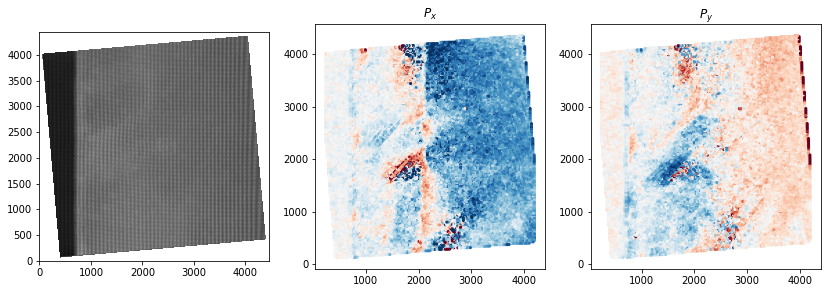

In [ ]:
dataset = dataset_all["Sm_10_0"]

main_img = dataset["main_image"]
Pxy = dataset["Pxy"]
xy_com = dataset["xy_COM"]
xy_atms = dataset['xy_atms']

_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4.5))
ax1.imshow(main_img, cmap="gray", origin="lower")
ax2.scatter(xy_com[:, 1], xy_com[:, 0], s=4, c=Pxy[:, 0], cmap='RdBu', vmin=-4, vmax=4)
ax3.scatter(xy_com[:, 1], xy_com[:, 0], s=4, c=Pxy[:, 1], cmap='RdBu', vmin=-4, vmax=4)
ax2.set_title("$P_x$")
ax3.set_title("$P_y$")
plt.show()

Next, we extract image patches centered around specific atom type and get the polarization values associated with each extracted patch:

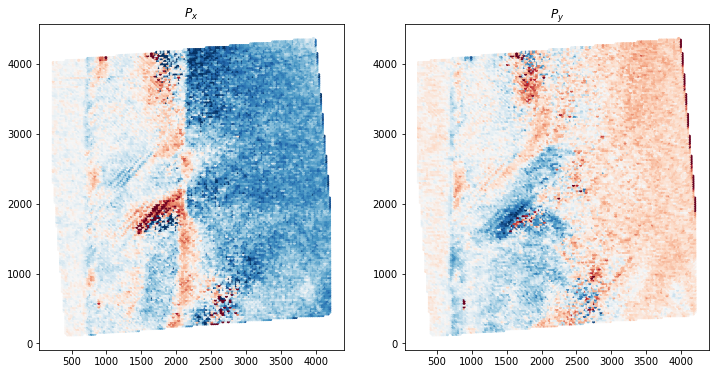

In [ ]:
patch_size = 42

# get stack of image patches centered on atoms
imgstack, xy_stack, _ = aoi.utils.extract_subimages(
    main_img[None, ..., None], xy_atms, patch_size, coord_class=0)
imgstack = imgstack[..., 0]

# Get polarization values for each image in the stack
tree = cKDTree(xy_com)
d, idx = tree.query(xy_stack, distance_upper_bound=10)
idx = idx[d!=np.inf]
xy_stack = xy_com[idx]
Pxy_stack = Pxy[idx]

# Plot the results (P value at the xy center position of each patch)
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.scatter(xy_stack[:, 1], xy_stack[:, 0], s=4, c=Pxy_stack[:, 0], cmap='RdBu', vmin=-4, vmax=4)
ax2.scatter(xy_stack[:, 1], xy_stack[:, 0], s=4, c=Pxy_stack[:, 1], cmap='RdBu', vmin=-4, vmax=4)
ax1.set_title('$P_x$')
ax2.set_title('$P_y$');

This is how our inputs into DKL-GP regressor look like. The outputs are polarization value(s).

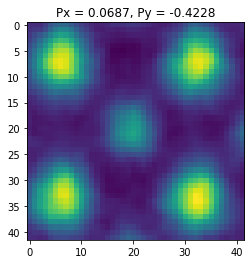

In [ ]:
k = 5000
plt.imshow(imgstack[k])
plt.title("Px = {}, Py = {}".format(*Pxy_stack[k].round(4)));

## Single-output DKL-GP regression on the entire dataset

The image patches wil serve as the inputs into the DKL-GP regressor and the polarization values will be our targets. First, weare going perform a single output regression, i.e. we are going to predict a single component (x or y) from structural data.

In [ ]:
# flatten image dimensions
n, d1, d2 = imgstack.shape
X = imgstack.reshape(n, d1*d2)
# get a single polarization component
y = Pxy_stack[:, 0]

Initialize and train DKL-GP regressor:

In [ ]:
data_dim = X.shape[-1]

# Initialize model
dklgp = aoi.models.dklGPR(data_dim)
# Train
dklgp.fit(
    X, y, # inputs and outputs
    training_cycles=150, precision="single", lr=1e-2  # training parameters
)

Epoch 1/150 ... Training loss: 1.0515
Epoch 10/150 ... Training loss: 0.858
Epoch 20/150 ... Training loss: 0.7832
Epoch 30/150 ... Training loss: 0.7255
Epoch 40/150 ... Training loss: 0.6829
Epoch 50/150 ... Training loss: 0.6452
Epoch 60/150 ... Training loss: 0.6118
Epoch 70/150 ... Training loss: 0.5712
Epoch 80/150 ... Training loss: 0.5745
Epoch 90/150 ... Training loss: 0.521
Epoch 100/150 ... Training loss: 0.474
Epoch 110/150 ... Training loss: 0.4438
Epoch 120/150 ... Training loss: 0.3795
Epoch 130/150 ... Training loss: 0.3296
Epoch 140/150 ... Training loss: 0.2806
Epoch 150/150 ... Training loss: 0.2335


Sample from the DKL-GP posterior to compute mean prediction and associated uncertainty for each input image patch (here, we are basically checking how well our model fitted the data):

In [ ]:
samples = dklgp.sample_from_posterior(X)
mean, var = samples.mean(0), samples.var(0)

Plot the results:

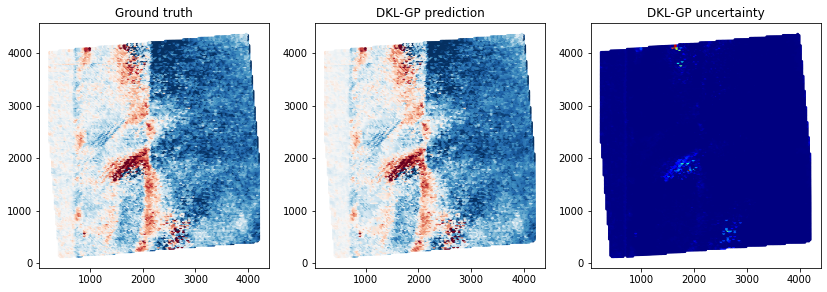

In [ ]:
_, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4.5))
ax1.scatter(xy_stack[:, 1], xy_stack[:, 0], s=4, c=y, cmap='RdBu', vmin=-3, vmax=3)
ax2.scatter(xy_stack[:, 1], xy_stack[:, 0], s=4, c=mean, cmap='RdBu', vmin=-3, vmax=3)
ax3.scatter(xy_stack[:, 1], xy_stack[:, 0], s=4, c=var, cmap='jet')
ax1.set_title("Ground truth")
ax2.set_title("DKL-GP prediction")
ax3.set_title("DKL-GP uncertainty")
plt.show()

## Single-output DKL-GP regression: training + test

Now let's use only part of the data for training. Then we will make a prediction on the entire dataset (train + test sets).

In [ ]:
split_ = 2500

X_p = X[xy_stack[:, 1]>split_]
y_p = y[xy_stack[:, 1]>split_]

Initialize and train DKL-GP:

In [ ]:
dklgp = aoi.models.dklGPR(data_dim)
dklgp.fit(X_p, y_p, training_cycles=150, precision="single", lr=1e-2)

Epoch 1/150 ... Training loss: 0.9285
Epoch 10/150 ... Training loss: 0.7742
Epoch 20/150 ... Training loss: 0.7361
Epoch 30/150 ... Training loss: 0.6981
Epoch 40/150 ... Training loss: 0.6597
Epoch 50/150 ... Training loss: 0.6219
Epoch 60/150 ... Training loss: 0.5829
Epoch 70/150 ... Training loss: 0.5421
Epoch 80/150 ... Training loss: 0.4971
Epoch 90/150 ... Training loss: 0.4499
Epoch 100/150 ... Training loss: 0.3913
Epoch 110/150 ... Training loss: 0.3681
Epoch 120/150 ... Training loss: 0.3018
Epoch 130/150 ... Training loss: 0.2448
Epoch 140/150 ... Training loss: 0.1832
Epoch 150/150 ... Training loss: 0.1319


Obtain the mean prediction and the associated uncertainty for the entire dataset (train + test):

In [ ]:
samples = dklgp.sample_from_posterior(X)
mean, var = samples.mean(0), samples.var(0)

Plot the results:

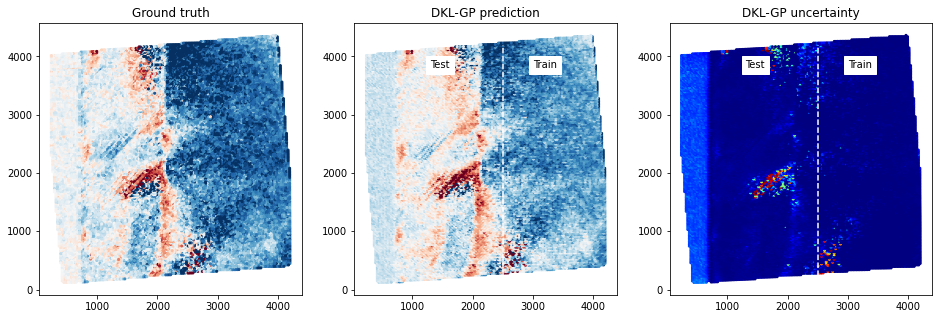

In [ ]:
annotate = True  # you may need to adjust position of the train/test annotations if you change the split_ value

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
ax1.scatter(xy_com[:, 1], xy_com[:, 0], s=4, c=Pxy[:, 0], cmap='RdBu', vmin=-3, vmax=3)
ax2.scatter(xy_stack[:, 1], xy_stack[:, 0], s=4, c=mean, cmap='RdBu', vmin=-3, vmax=3)
ax3.scatter(xy_stack[:, 1], xy_stack[:, 0], s=4, c=var, cmap='jet')
ax1.set_title("Ground truth")
ax2.set_title("DKL-GP prediction")
ax3.set_title("DKL-GP uncertainty")
if annotate:
    for _ax in fig.axes[1:]:
        _ax.vlines(split_, xy_com[:, 1].min(), xy_com[:, 1].max(), linestyle='--', color='w')
        _ax.annotate("Train", (3000, 3800), color='k', backgroundcolor='w')
        _ax.annotate("Test", (1300, 3800), color='k', backgroundcolor='w')
plt.show()

## Multi-output DKL-GP regression: train + test

Now let's perform a multi-output DKL-GP regression, i.e. we are going to predict both components of polarization simultaneously.

In [ ]:
y = Pxy_stack
y.shape

(22766, 2)

Split the data into the training and test parts (same as before):

In [ ]:
split_ = 2500

X_p = X[xy_stack[:, 1]>split_]
y_p = y[xy_stack[:, 1]>split_].T

Initialize and train DKL-GP regressor:

In [ ]:
dklgp = aoi.models.dklGPR(data_dim)
dklgp.fit(X_p, y_p, training_cycles=300, precision="single", lr=1e-3)

Epoch 1/300 ... Training loss: 1.9678
Epoch 10/300 ... Training loss: 1.6229
Epoch 20/300 ... Training loss: 1.6077
Epoch 30/300 ... Training loss: 1.5864
Epoch 40/300 ... Training loss: 1.5744
Epoch 50/300 ... Training loss: 1.5515
Epoch 60/300 ... Training loss: 1.5359
Epoch 70/300 ... Training loss: 1.618
Epoch 80/300 ... Training loss: 1.5484
Epoch 90/300 ... Training loss: 1.5226
Epoch 100/300 ... Training loss: 1.5044
Epoch 110/300 ... Training loss: 1.4872
Epoch 120/300 ... Training loss: 1.4721
Epoch 130/300 ... Training loss: 1.4567
Epoch 140/300 ... Training loss: 1.442
Epoch 150/300 ... Training loss: 1.4275
Epoch 160/300 ... Training loss: 1.4432
Epoch 170/300 ... Training loss: 1.4064
Epoch 180/300 ... Training loss: 1.3954
Epoch 190/300 ... Training loss: 1.3929
Epoch 200/300 ... Training loss: 1.372
Epoch 210/300 ... Training loss: 1.3596
Epoch 220/300 ... Training loss: 1.3492
Epoch 230/300 ... Training loss: 1.3412
Epoch 240/300 ... Training loss: 1.3355
Epoch 250/300 

Obtain the mean prediction and the associated uncertainty for the entire dataset (train + test):

In [ ]:
samples = dklgp.sample_from_posterior(X)
mean, var = samples.mean(0), samples.var(0)

Plot the results:

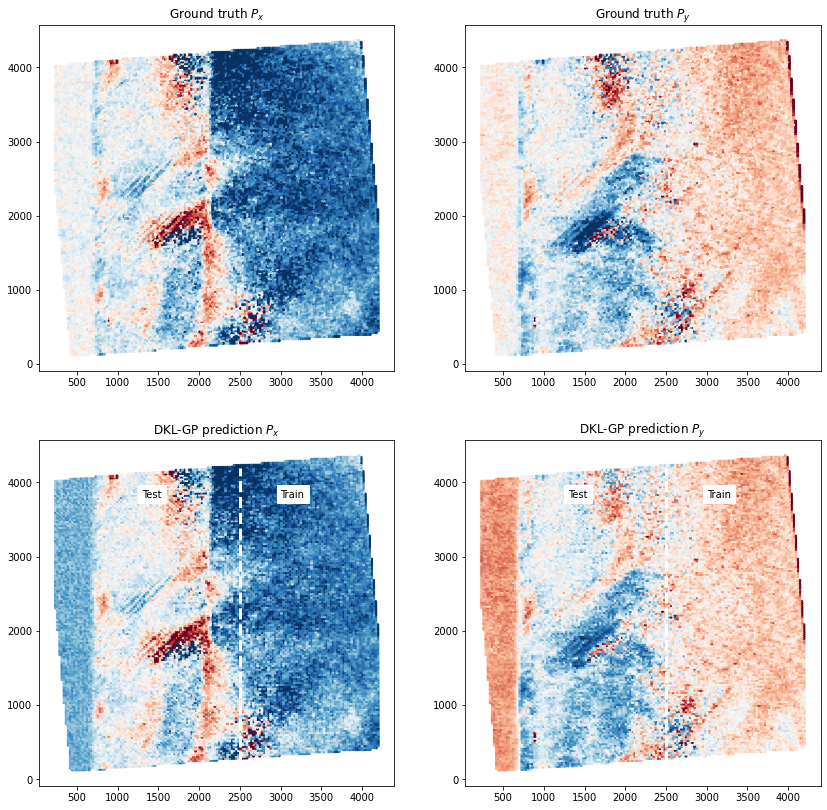

In [ ]:
annotate = True  # you may need to adjust position of the train/test annotations if you change the split_ value

fig, ax = plt.subplots(2, 2, figsize=(14, 14))
ax[0, 0].scatter(xy_com[:, 1], xy_com[:, 0], s=4, c=Pxy[:, 0], cmap='RdBu', vmin=-3, vmax=3)
ax[0, 1].scatter(xy_com[:, 1], xy_com[:, 0], s=4, c=Pxy[:, 1], cmap='RdBu', vmin=-3, vmax=3)
ax[1, 0].scatter(xy_stack[:, 1], xy_stack[:, 0], s=4, c=mean[0, :], cmap='RdBu', vmin=-3, vmax=3)
ax[1, 1].scatter(xy_stack[:, 1], xy_stack[:, 0], s=4, c=mean[1, :], cmap='RdBu', vmin=-3, vmax=3)
ax[0, 0].set_title("Ground truth $P_x$")
ax[0, 1].set_title("Ground truth $P_y$")
ax[1, 0].set_title("DKL-GP prediction $P_x$")
ax[1, 1].set_title("DKL-GP prediction $P_y$")
if annotate:
    for _ax in fig.axes[2:]:
        _ax.vlines(split_, xy_com[:, 1].min(), xy_com[:, 1].max(), linestyle='--', linewidth=3, color='w')
        _ax.annotate("Train", (3000, 3800), color='k', backgroundcolor='w')
        _ax.annotate("Test", (1300, 3800), color='k', backgroundcolor='w')
plt.show()

We were able to obtain reasonably accurate predictions except for the substrate part. Now let's modify our training set so that it includes a part of the substrate:

In [ ]:
split_ = 1500

X_p = X[xy_stack[:, 0]<split_]
y_p = y[xy_stack[:, 0]<split_].T

# Train
dklgp = aoi.models.dklGPR(data_dim)
dklgp.fit(X_p, y_p, training_cycles=300, precision="single", lr=1e-3)

# Predict
samples = dklgp.sample_from_posterior(X)
mean, var = samples.mean(0), samples.var(0)

Epoch 1/300 ... Training loss: 2.2093
Epoch 10/300 ... Training loss: 1.7729
Epoch 20/300 ... Training loss: 1.7144
Epoch 30/300 ... Training loss: 1.6353
Epoch 40/300 ... Training loss: 1.7504
Epoch 50/300 ... Training loss: 1.6794
Epoch 60/300 ... Training loss: 1.6157
Epoch 70/300 ... Training loss: 1.5942
Epoch 80/300 ... Training loss: 1.5683
Epoch 90/300 ... Training loss: 1.5586
Epoch 100/300 ... Training loss: 1.544
Epoch 110/300 ... Training loss: 1.533
Epoch 120/300 ... Training loss: 1.5217
Epoch 130/300 ... Training loss: 1.5097
Epoch 140/300 ... Training loss: 1.5076
Epoch 150/300 ... Training loss: 1.491
Epoch 160/300 ... Training loss: 1.4769
Epoch 170/300 ... Training loss: 1.4886
Epoch 180/300 ... Training loss: 1.4639
Epoch 190/300 ... Training loss: 1.4732
Epoch 200/300 ... Training loss: 1.4383
Epoch 210/300 ... Training loss: 1.4273
Epoch 220/300 ... Training loss: 1.4164
Epoch 230/300 ... Training loss: 1.4181
Epoch 240/300 ... Training loss: 1.4061
Epoch 250/300 

Plot the results:

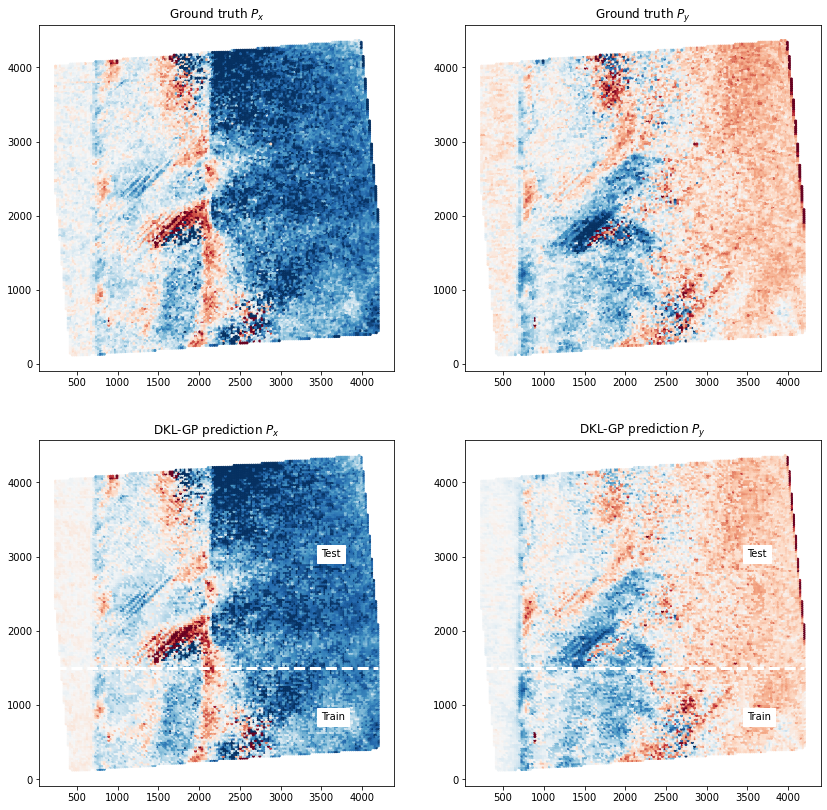

In [ ]:
annotate = True  # you may need to adjust position of the train/test annotations if you change the split_ value

fig, ax = plt.subplots(2, 2, figsize=(14, 14))
ax[0, 0].scatter(xy_com[:, 1], xy_com[:, 0], s=4, c=Pxy[:, 0], cmap='RdBu', vmin=-3, vmax=3)
ax[0, 1].scatter(xy_com[:, 1], xy_com[:, 0], s=4, c=Pxy[:, 1], cmap='RdBu', vmin=-3, vmax=3)
ax[1, 0].scatter(xy_stack[:, 1], xy_stack[:, 0], s=4, c=mean[0, :], cmap='RdBu', vmin=-3, vmax=3)
ax[1, 1].scatter(xy_stack[:, 1], xy_stack[:, 0], s=4, c=mean[1, :], cmap='RdBu', vmin=-3, vmax=3)
ax[0, 0].set_title("Ground truth $P_x$")
ax[0, 1].set_title("Ground truth $P_y$")
ax[1, 0].set_title("DKL-GP prediction $P_x$")
ax[1, 1].set_title("DKL-GP prediction $P_y$")
if annotate:
    for _ax in fig.axes[2:]:
        _ax.hlines(split_, xy_com[:, 1].min(), xy_com[:, 1].max(), linestyle='--', linewidth=3, color='w')
        _ax.annotate("Train", (3500, 800), color='k', backgroundcolor='w')
        _ax.annotate("Test", (3500, 3000), color='k', backgroundcolor='w')
plt.show()

We can also compare distributions of predicted polarization values with those of the ground truth values. Let's do it for test data only:

In [ ]:
X_t = X[xy_stack[:, 0]>split_]
y_t = y[xy_stack[:, 0]>split_]

samples = dklgp.sample_from_posterior(X_t)
mean_t, _ = samples.mean(0), samples.var(0)

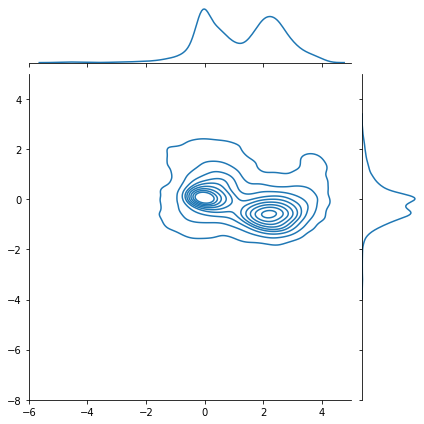

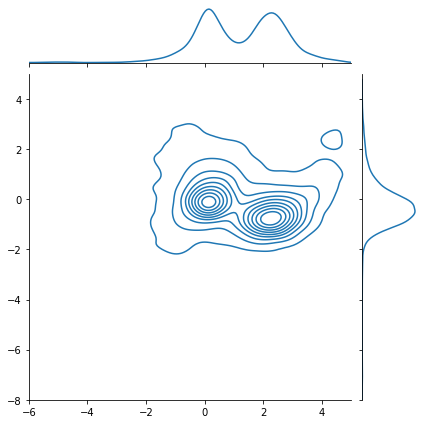

In [ ]:
sns.jointplot(x=mean_t[0,:], y=mean_t[1,:], kind="kde", xlim=(-6, 5), ylim=(-8, 5));
sns.jointplot(x=y_t[:,0], y=y_t[:,1], kind="kde", xlim=(-6, 5), ylim=(-8, 5));